High level story:

1. word cloud and barriers number histogram - what barriers do learners face? 
2. correlation, how do these barriers relate to each other? can we explore these relationships in more detail?
3. Likert diagrams to explore differences between programs/ regions, highlight interesting findings
4. visualise the flow of grads from bootcamp to 6months post-bootcamp. does placement speed vary per region? per programme? and how do the barriers factor in?

Questions for clarification: 
- what barriers/ metrics is the feature "barriers value" based on?

# Generation Exploratory Data Analysis
####   Megan Guidry | March 2024 

## Objective

#### The Dataset

- The original dataset has 2602 observations. Each observation represents a learner that has been admitted onto a Generation UK&I bootcamp.
- This analysis will focus on tech bootcamps. After removing non-tech bootcamps from the dataset there are 1917 observations.
  
Program Names:
- Technology - Cloud Operations Engineer
- Technology - Data Engineering
- Data Analytics
- IT Support
- Tech Talent Accelerator - Software Engineering
- Google Cloud


- regions,
- feature names.

#### Questions 
- Q1
- Q2
- Q3

In [52]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import plotly.graph_objects as go

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from pandas.api.types import CategoricalDtype
from scipy import stats

## Data Cleaning

In [28]:
# Reading the data and combining the two data sources:
PowerBI_df = pd.read_csv("Gen_Data/data_improved_including DE_AWS.csv")
SF_df = pd.read_csv("Gen_Data/Grad_attendance_info.xls.csv")

SF_df.rename(columns={"Learner Name":"LearnerName"}, inplace=True) #renaming the column required for merging

gen_df = pd.merge(PowerBI_df, SF_df, left_on='LearnerName', right_on='LearnerName')

In [29]:
# Filter the data so that we are only looking at tech programmes:
gen_df = gen_df[gen_df["ProgramName"].isin(["Technology - Cloud Operations Engineer", 
                                                 "Technology - Data Engineering", 
                                                 "Data Analytics", "IT Support", 
                                                 "Tech Talent Accelerator - Software Engineering", 
                                                 "Google Cloud"])]

In [105]:
# Remove Dublin, this is the only Irish cohort and is an outlier in the dataset:
gen_df = gen_df.drop(gen_df[gen_df["Cohort_City"]=="Dublin"].index)

## Exploratory Data Analysis

#### What barriers do Generation UK & I learners face?

In this analysis we look specifically into 15 different situational or demographic barriers:
-   asylumSeeker                            
-   Education level                         
-   gender                                  
-   has_degree                              
-   Has_dependents                          
-   IMD_decile                              
-   Is_30_or_over                           
-   Is_disabled                            
-   is_EAL                                 
-   is_ethnic_minority                      
-   is_LGBTQ+                               
-   is_lone_parent                         
-   is_low_socio_econ                       
-   is_unempl_12+_mths                      
-   is_unemployed_pre_gen

NOTE: The feature "Barriers value" is a count of all the barriers metrics that describe an individual learner.            

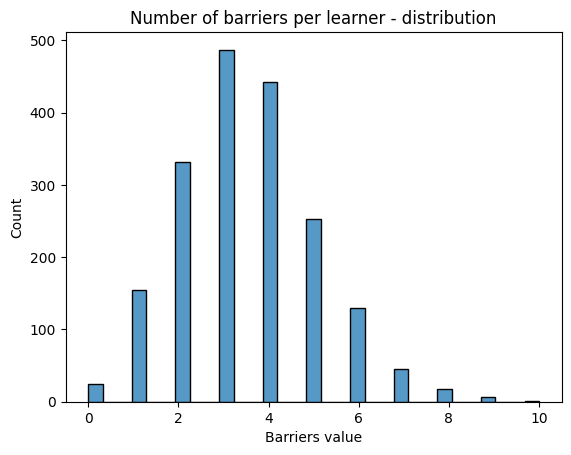

In [106]:
sns.histplot(data= gen_df, 
             x="Barriers value"
            )

plt.title("Number of barriers per learner - distribution")
plt.show()

#### How do these barriers correlate with each other and with other learner fetures?

I will create a heatmap for visualising the relationships that exist between the barriers metrics. Before creating a heatmap in python there are three things I need to consider:
1. Handle missing data
2. remove outliers that may skew the results
3. assign ordinality to my categorical data where necessary 

##### Preparing my data for the heatmap

##### cleaning specific features ahead of heatmap correlation analysis

There are quite a lot of missing data in this dataset. for that reason I have carefully selected features that are as complete as possible to use for the correlation analysis. The features that were excluded from this portion of the EDA due to high numbers of NaN valuse include:

Features excluded from heatmap analysis due to large % of NaN:
- is_low_socio_econ
- is_unempl_12+_mths
- is_unemployed_pre_gen
- Job_start_speed
- socioeconStatusMap - needs ordinality assigned
- Average Score - Soft Skills
- Average Score - Technical Skills

Features included:
- asylumSeeker*
- Barriers value
- Education level
- has_degree
- Has_dependents*
- IMD_decile*
- Is_30_or_over
- Is_disabled
- is_EAL
- is_ethnic_minority*
- is_LGBTQ+*
- is_lone_parent*
- Days Since Cohort Graduation
- Total Days Absent
- Total Days Late

The features that have a star need data imputed. For most of these features (asylumSeeker, Has_dependents, is_ethnic_minority, is_LGBTQ, is_lone_parent) replaceing a null value with 0 is sufficient. This is because assigning a value of zero is equivalent to assuming this individual does not have this barrier. The error and bias from incorrectly lableing someone as having the barrier is greater than if we incorrectly lable someone as lacking the barrier. Aditionally, removing the rows completely would remove valuable data from other columns.

Data imputation for the feature IMD_decile will be handled separately.

In [107]:
# Assigning ordinality to categorical features:

socioeconStatusMap_levels = CategoricalDtype(categories=["Exclude", "Lower socio-economic backgrounds", "Intermediate backgrounds", "Professional backgrounds"], ordered=True)
gen_df["socioeconStatusMap_ordered"] = gen_df["socioeconStatusMap"].astype(socioeconStatusMap_levels)

asylumSeeker_levels = CategoricalDtype(categories=["No", "Choose not to say", "Yes"], ordered=True)
gen_df["asylumSeeker_ordered"] = gen_df["asylumSeeker"].astype(asylumSeeker_levels)


In [108]:
# cleaning specific features ahead of heatmap correlation analysis:
# asylumSeeker, Has_dependents, is_ethnic_minority, is_LGBTQ+, is_lone_parent

# Cleaning asylumSeeker:
gen_df["asylumSeeker"].fillna(0, inplace=True)

# Cleaning Has_dependents:
gen_df["Has_dependents"].fillna(0, inplace=True)

# Cleaning is_ethnic_minority
gen_df["is_ethnic_minority"].fillna(0, inplace=True)

# Cleaning is_LGBTQ+
gen_df["is_LGBTQ+"].fillna(0, inplace=True)

# Cleaning is_lone_parent
gen_df["is_lone_parent"].fillna(0, inplace=True)


In [109]:
# Fill the NaN values for the feature IMD_decile:


In [110]:
# selecting the columns wanted for the heatmap and creating a df.

heatmap_df = gen_df[['asylumSeeker_ordered', 
                     'Barriers value',
                     'Education level',
                     'has_degree', 
                     'Has_dependents',
                     'IMD_decile',
                     'Is_30_or_over', 
                     'Is_disabled', 
                     'is_EAL', 
                     'is_ethnic_minority',
                     'is_LGBTQ+', 
                     'is_lone_parent', 
                     'Days Since Cohort Graduation',
                     'Total Days Absent', 
                     'Total Days Late',
                    ]]

In [117]:
heatmap_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1892 entries, 56 to 2601
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   asylumSeeker_ordered          1442 non-null   category
 1   Barriers value                1892 non-null   int64   
 2   Education level               1892 non-null   object  
 3   has_degree                    1892 non-null   float64 
 4   Has_dependents                1892 non-null   float64 
 5   IMD_decile                    1700 non-null   float64 
 6   Is_30_or_over                 1892 non-null   int64   
 7   Is_disabled                   1892 non-null   int64   
 8   is_EAL                        1892 non-null   int64   
 9   is_ethnic_minority            1892 non-null   float64 
 10  is_LGBTQ+                     1892 non-null   float64 
 11  is_lone_parent                1892 non-null   float64 
 12  Days Since Cohort Graduation  1892 non-null   int64 

In [112]:
gen_df.columns

Index(['ProgramName', 'Cohort_name', 'Student_ID', 'LearnerName',
       'Age_at_application', 'areaLocal', 'asylumSeeker', 'Barriers value',
       'birthDate', 'Cohort_City', 'Current_Employer_Name',
       'Current_placement_aligned_to_training', 'Current_position',
       'education', 'Education level', 'educationStatusAtApplication',
       'Employed_within_180D', 'Employed_within_90D', 'Employment_Status',
       'employmentIndustryPreGen', 'employmentSatisfactionPreGen',
       'employmentStatusPreGen', 'employmentTypePreGen',
       'englishFirstLanguage', 'Enrolment_Status', 'Ethnicity_Group',
       'First_placement_by_gen', 'First_Placement_Date', 'gender',
       'has_degree', 'Has_dependents', 'has_worked_5+_years', 'IMD_decile',
       'Is_30_or_over', 'Is_disabled', 'is_EAL', 'is_ethnic_minority',
       'is_LGBTQ+', 'is_lone_parent', 'is_low_socio_econ',
       'is_unempl_12+_mths', 'is_unemployed_pre_gen',
       'is_unsatisfied_empl_pre_gen', 'Job_start_speed',
      

In [113]:
isnull_temp = gen_df[['asylumSeeker_ordered',
                     'Barriers value',
                     'Education level',
                     'has_degree', 
                     'Has_dependents',
                     'IMD_decile',
                     'Is_30_or_over', 
                     'Is_disabled', 
                     'is_EAL', 
                     'is_ethnic_minority',
                     'is_LGBTQ+', 
                     'is_lone_parent', 
                     'Days Since Cohort Graduation',
                     'Total Days Absent', 
                     'Total Days Late',
                    ]].isnull().groupby(gen_df["Cohort_name"]).sum()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
isnull_temp

,asylumSeeker_ordered,Barriers value,Education level,has_degree,Has_dependents,IMD_decile,Is_30_or_over,Is_disabled,is_EAL,is_ethnic_minority,is_LGBTQ+,is_lone_parent,Days Since Cohort Graduation,Total Days Absent,Total Days Late
Cohort_name,,,,,,,,,,,,,,,
AWS BIR 1,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AWS BIR 2,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AWS LEE1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AWS LON1,21,0,0,0,0,3,0,0,0,0,0,0,0,0,0
AWS LON2,21,0,0,0,0,2,0,0,0,0,0,0,0,0,0
AWS LON3,21,0,0,0,0,3,0,0,0,0,0,0,0,0,0
AWS LON4,25,0,0,0,0,2,0,0,0,0,0,0,0,0,0
AWS LON5,26,0,0,0,0,3,0,0,0,0,0,0,0,0,0
AWS LON6,22,0,0,0,0,2,0,0,0,0,0,0,0,0,0


<Axes: xlabel='IMD_decile', ylabel='Count'>

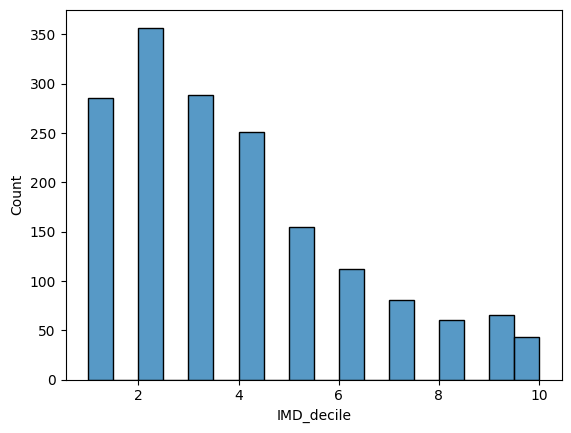

In [118]:
sns.histplot(x=gen_df["IMD_decile"])

In [115]:
asylumSeeker - fillnull 0
Has_dependents (45 null, 2.3%) - fillnull 0?



SyntaxError: invalid syntax (3890610273.py, line 1)

In [116]:
# Extracting column names from the heatmap df
column_names=heatmap_df.columns

# Assiging column names to row indexs to create the matrix
chisqmatrix=pd.DataFrame(heatmap_df,columns=column_names,index=column_names)

In [53]:
# Setting counters to zero
outercnt=0
innercnt=0

for icol in column_names: # Outer loop
    for jcol in column_names: # inner loop
         # Converting to cross tab as for CHi-square test we have
         # to first convert variables into contigency table
         mycrosstab=pd.crosstab(heatmap_df[icol],heatmap_df[jcol])
        
         #Getting p-value and other usefull information
         stat,p,dof,expected=stats.chi2_contingency(mycrosstab)
        
         # Rounding very small p-values to zero
         chisqmatrix.iloc[outercnt,innercnt]=round(p,5)
        
         # As mentioned above Expected frequencies should be at 
         # least 5 for the majority (80%) of the cells.
         # Here we are checking expected frequency of each group
         cntexpected=expected[expected<5].size

         #Getting percentage 
         perexpected=((expected.size-cntexpected)/expected.size)*100

In [59]:
if perexpected<20:
    chisqmatrix.iloc[outercnt,innercnt]=2 #Assigning 2
 
if icol==jcol:
    chisqmatrix.iloc[outercnt,innercnt]=0.00
    innercnt=innercnt+1
    outercnt=outercnt+1
    innercnt=0

,asylumSeeker,Barriers value,Education level,has_degree,Has_dependents,IMD_decile,Is_30_or_over,Is_disabled,is_EAL,is_ethnic_minority,...,is_low_socio_econ,is_unempl_12+_mths,is_unemployed_pre_gen,Job_start_speed,socioeconStatusMap_ordered,Days Since Cohort Graduation,Total Days Absent,Total Days Late,Average Score - Soft Skills,Average Score - Technical Skills
asylumSeeker,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Barriers value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education level,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Has_dependents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMD_decile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Is_30_or_over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Is_disabled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_EAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_ethnic_minority,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Are there program-specific or region-specific trends in these barriers and their impact on placement outcomes?

#### does placement speed vary per region? per programme? and how do the barriers factor in?

## Summary

## Next steps